In [0]:
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

1.1 Implement gradient-based factorisation using PyTorch’s AD (1 mark)

In [14]:
from typing import Tuple
from torch.autograd import Variable

def sgd_factorise_ad(A, r, N, lr):
  # initialised
  m, n = A.shape
  U = Variable(torch.rand(m, r),requires_grad=True)
  V = Variable(torch.rand(n, r),requires_grad=True)
   
  for epoch in range(N):
    # iterative update
    loss_fn = torch.nn.MSELoss(reduction = 'sum')
    e = loss_fn(A, U@V.t())
    e.backward()
    U.data = U.data - lr*U.grad.data
    V.data = V.data - lr*V.grad.data
    U.grad.data.zero_()
    V.grad.data.zero_()

  return U, V


A = torch.Tensor([[0.3374,0.6005,0.1735], 
                  [3.3359,0.0492,1.8374], 
                  [2.9407,0.5301,2.2620]])
r = 2
N = 1000
lr = 0.01

U, V = sgd_factorise_ad(A,r,N,lr)
print("U:")
print(U)
print("V:")
print(V)

loss_fn = torch.nn.MSELoss(reduction = 'sum')
lossAD = loss_fn(A, U@V.t())
print(lossAD)

U:
tensor([[-0.1032,  0.5840],
        [ 1.7575,  0.3827],
        [ 1.3791,  1.0075]], requires_grad=True)
V:
tensor([[ 1.7021,  0.6849],
        [-0.1919,  0.8568],
        [ 0.9519,  0.7843]], requires_grad=True)
tensor(0.1219, grad_fn=<SumBackward0>)


1.2 Factorise and compute reconstruction error on real data (1 mark)

In [75]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'+'/iris/iris.data', header=None)
data = torch.tensor(df.iloc[:, [0,1,2,3]].values)
data = data - data.mean(dim=0)

r = 2
N = 1000
lr = 0.01

U, V = sgd_factorise_ad(data,r,N,lr)
loss_fn = torch.nn.MSELoss(reduction = 'sum')
loss_iris = loss_fn(data, U@V.t())
print("sgd reconstruction loss:", loss_iris)

u, s, v = torch.svd(data)
s[2]=s[3]=0
data_svd = torch.mm(torch.mm(u, torch.diag(s)), v.t())
loss_svd = loss_fn(data, data_svd)
print("svd reconstruction loss:", loss_svd)

sgd reconstruction loss: tensor(15.2289, dtype=torch.float64, grad_fn=<SumBackward0>)
svd reconstruction loss: tensor(15.2288, dtype=torch.float64)


1.3 Compare against PCA (1 mark)

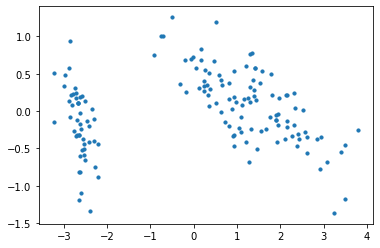

In [106]:
import matplotlib.pyplot as plt

u, s, v = torch.svd(data)
s[2]=s[3]=0
svd_data = torch.mm(u, torch.diag(s))
plt.scatter(svd_data[:,0],svd_data[:,1],s=10)

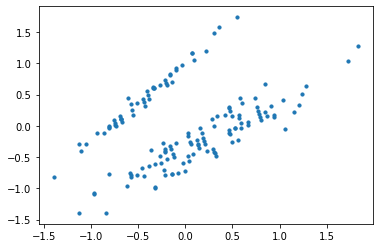

In [109]:
U, V = sgd_factorise_ad(data,r,N,lr)
plt.scatter(U.data[:,0],U.data[:,1],s=10)

2.1 Implement the MLP (1 mark)

In [0]:
import pandas as pd
import numpy as np

def train(data_tr, targets_tr, data_va, targets_va, N, lr):
    # initialised
    W1 = Variable(torch.randn(4,12), requires_grad=True)
    W2 = Variable(torch.randn(12,3), requires_grad=True)
    b1 = Variable(torch.tensor(0.0), requires_grad=True)
    b2 = Variable(torch.tensor(0.0), requires_grad=True)   

    # train
    for epoch in range(N):
      logits = torch.relu(data_tr @ W1 + b1) @ W2 +b2
      loss = torch.nn.functional.cross_entropy(logits, targets_tr)
      loss.backward()
      with torch.no_grad():
        W1.data = W1.data - lr*W1.grad.data
        W2.data = W2.data - lr*W2.grad.data
        b1.data = b1.data - lr*b1.grad.data
        b2.data = b2.data - lr*b2.grad.data
      W1.grad.data.zero_()
      W2.grad.data.zero_()
      b1.grad.data.zero_()
      b2.grad.data.zero_()
    
    # validation
    y_tr_pr = torch.relu(data_tr @ W1 + b1) @ W2 +b2
    y_tr_pred = list(map(lambda x:np.argmax(x), y_tr_pr.data.numpy()))
    acc_tr = sum(y_tr_pred == targets_tr.numpy())/len(data_tr)

    y_va_pr = torch.relu(data_va @ W1 + b1) @ W2 +b2
    y_va_pred = list(map(lambda x:np.argmax(x), y_va_pr.data.numpy()))
    acc_va = sum(y_va_pred == targets_va.numpy())/len(data_va)

    return acc_tr, acc_va


2.2 Test the MLP (1 mark)

In [61]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'+'/iris/iris.data', header=None)
df = df.sample(frac=1) #shuffle

# add label indices column
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

# normalise data
alldata = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

# create datasets
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
data_tr = alldata[:100]
data_va = alldata[100:]

N = 100
lr = 0.01

for i in range(10):
  acc_tr, acc_va = train(data_tr, targets_tr, data_va, targets_va, N, lr)
  print(i+1,"training accuracy:", acc_tr,"validation accuracy:", acc_va)

1 training accuracy: 0.77 validation accuracy: 0.74
2 training accuracy: 0.89 validation accuracy: 0.88
3 training accuracy: 0.59 validation accuracy: 0.6
4 training accuracy: 0.43 validation accuracy: 0.42
5 training accuracy: 0.77 validation accuracy: 0.78
6 training accuracy: 0.82 validation accuracy: 0.76
7 training accuracy: 0.72 validation accuracy: 0.68
8 training accuracy: 0.78 validation accuracy: 0.76
9 training accuracy: 0.79 validation accuracy: 0.78
10 training accuracy: 0.81 validation accuracy: 0.8
